# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [544]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 읽어오기


In [545]:
RANDOM_STATE = 110

train_data = pd.read_csv("../../data/train_data.csv")
test_data = pd.read_csv("../../data/test_data.csv")

---

반복적으로 쓰는 툴 함수화

In [546]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

In [547]:
def value_counts_ratio(df, col_name, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [548]:
def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

In [549]:
def plot_ratio(df, group_by_column, target_column='target', abnormal_value='AbNormal'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AbNormal' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 AbNormal 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

In [550]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_abnormal_ratio(dataframe, column_name, target_name, target_value, bins=20):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하고 막대그래프로 표시하는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    target_value (str): 타겟 변수의 특정 값
    bins (int): 구간의 수 (기본값은 20)
    """
    def abnormal_ratio(dataframe, column_name, target_name, target_value):
        """
        주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하는 함수.

        Parameters:
        dataframe (pd.DataFrame): 데이터프레임
        column_name (str): 열 이름
        target_name (str): 타겟 변수 이름
        target_value (str): 타겟 변수의 특정 값

        Returns:
        pd.DataFrame: 각 값마다 타겟 변수의 특정 값 비율을 포함하는 데이터프레임
        """
        # 각 값마다 타겟 변수의 특정 값 비율 계산
        value_counts = dataframe.groupby(column_name)[target_name].apply(lambda x: (x == target_value).mean()).reset_index()
        count_counts = dataframe.groupby(column_name)[target_name].count().reset_index()
        
        value_counts.columns = [column_name, 'ratio']
        count_counts.columns = [column_name, 'count']
        
        # 비율과 카운트를 병합
        result = pd.merge(value_counts, count_counts, on=column_name)
        return result

    # column_name 값을 지정된 구간으로 나누기
    dataframe[f'{column_name}_bins'] = pd.cut(dataframe[column_name], bins=bins)

    # 비율 계산
    ratios = abnormal_ratio(dataframe, f'{column_name}_bins', target_name, target_value)

    # 막대그래프 그리기
    plt.figure(figsize=(20, 10))
    barplot = sns.barplot(x=f'{column_name}_bins', y='ratio', data=ratios, color='skyblue')
    plt.xlabel(f'{column_name} (binned)')
    plt.ylabel('AbNormal Ratio')
    plt.title(f'AbNormal Ratio by {column_name} (binned)', pad=30)  # 제목과 그래프 사이의 간격 조정
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # 각 막대 위에 비율 값과 카운트 표시
    for p in barplot.patches:
        # 막대의 x 좌표에 해당하는 구간을 찾기
        bin_label = ratios[f'{column_name}_bins'].cat.categories[int(p.get_x() + p.get_width() / 2) - 1]
        count_value = ratios.loc[ratios[f'{column_name}_bins'] == bin_label, 'count'].values[0]
        barplot.annotate(f'{format(p.get_height(), ".2f")} ({count_value})', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')

    plt.show()

    # _bins 변수 드랍
    dataframe.drop(columns=[f'{column_name}_bins'], inplace=True)


---

## Dam

In [551]:
train_data.columns.to_list()

['Model.Suffix',
 'Workorder',
 'CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_D

In [552]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns.tolist()

# 추가적으로 불러올 열 이름
additional_cols = ['Workorder', 'Dispenser_num', 'target']

# 두 리스트를 합침
Process_Desc_col.extend(additional_cols)

# Dispenser_num이 2인 행만 필터링
filtered_data = train_data[train_data['Dispenser_num'] == '#2']

# 필요한 열만 선택하여 새로운 데이터프레임 생성
result_df = filtered_data[Process_Desc_col]

In [553]:
result_df.columns.to_list()

['CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y

In [554]:
train_data = result_df

In [555]:
summary_df = summarize_group(train_data, ['Dispenser_num','CURE START POSITION X Collect Result_Dam', 'CURE END POSITION X Collect Result_Dam'])

Grouped by: Dispenser_num, CURE START POSITION X Collect Result_Dam, CURE END POSITION X Collect Result_Dam

             group  'AdNormal' count     ratio  Total
0  (#2, 280, 1000)               850  0.054977  15461


'CURE START POSITION Z Collect Result_Dam' 33.5 값 하나만 존재로  
이전에 고윳값 1개에 대해서 제거하는 과정에서 빠짐

In [556]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'CURE' in col]


print("\n Dam 공정 관련 변수 중 CURE 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 CURE 포함 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam


In [557]:
import numpy as np

# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Dam'
start_z_col = 33.5
end_x_col = 'CURE END POSITION X Collect Result_Dam'
end_z_col = 'CURE END POSITION Z Collect Result_Dam'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

test_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

# 결과 확인
value_counts_ratio(train_data, 'CURE_DISTANCE_Dam', 'target')


CURE_DISTANCE_Dam별 target 비율 및 갯수

            AbNormal    Normal  AbNormal  Normal  Total
variable                                               
720.306185  0.054977  0.945023       850   14611  15461


C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


Dispenser 종류에 따라 좌표위치가 동일하게 따라감

In [558]:
summary_df = summarize_group(train_data, ['Dispenser_num','CURE START POSITION Θ Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam'])

Grouped by: Dispenser_num, CURE START POSITION Θ Collect Result_Dam, CURE END POSITION Θ Collect Result_Dam

          group  'AdNormal' count     ratio  Total
0  (#2, 90, 90)               850  0.054977  15461


Θ 각도도 마찬가지로 Dispenser 종류를 따라감

In [559]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'CURE' in col]


print("\n Dam 공정 관련 변수 중 CURE 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 CURE 포함 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
CURE_DISTANCE_Dam


In [560]:
summary_df = summarize_group(train_data, ['Dispenser_num','CURE SPEED Collect Result_Dam'])

Grouped by: Dispenser_num, CURE SPEED Collect Result_Dam

       group  'AdNormal' count     ratio  Total
0   (#2, 70)               697  0.055269  12611
1   (#2, 85)                72  0.071076   1013
2   (#2, 95)                 3  0.039474     76
3  (#2, 100)                39  0.038576   1011
4  (#2, 105)                39  0.052000    750


<Figure size 1000x500 with 0 Axes>

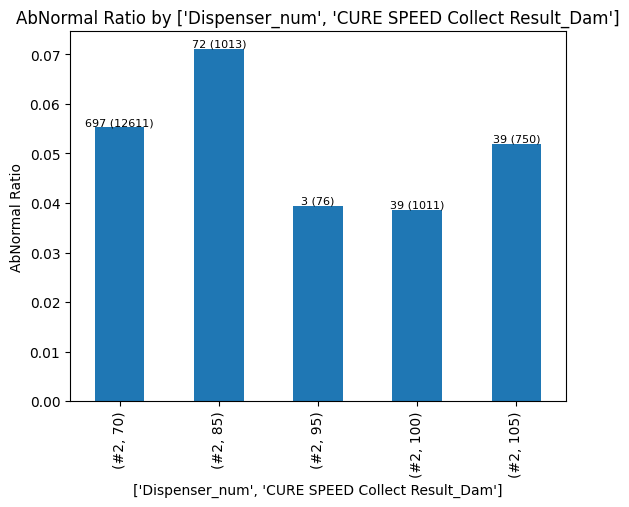

In [561]:
plot_ratio(train_data, ['Dispenser_num','CURE SPEED Collect Result_Dam'])

In [562]:
value_counts_ratio(train_data, 'CURE SPEED Collect Result_Dam', 'target')


CURE SPEED Collect Result_Dam별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
70        0.055269  0.944731       697   11914  12611
85        0.071076  0.928924        72     941   1013
95        0.039474  0.960526         3      73     76
100       0.038576  0.961424        39     972   1011
105       0.052000  0.948000        39     711    750


In [563]:
summary_df = summarize_group(train_data, ['Dispenser_num','CURE SPEED Collect Result_Dam'])

Grouped by: Dispenser_num, CURE SPEED Collect Result_Dam

       group  'AdNormal' count     ratio  Total
0   (#2, 70)               697  0.055269  12611
1   (#2, 85)                72  0.071076   1013
2   (#2, 95)                 3  0.039474     76
3  (#2, 100)                39  0.038576   1011
4  (#2, 105)                39  0.052000    750


In [564]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'CURE' in col]

print("\n Dam 공정 관련 변수 중 CURE 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 CURE 포함 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
CURE_DISTANCE_Dam


In [565]:
train_data.drop(columns=[
    'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'
    , 'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION X Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
], inplace=True)

test_data.drop(columns=[
    'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'
    , 'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION X Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
], inplace=True)

c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [566]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'CURE' in col]

print("\n Dam 공정 관련 변수 중 CURE 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE_DISTANCE_Dam


In [567]:
train_data['CURE_Time_Dam'] = train_data['CURE_DISTANCE_Dam'] / train_data['CURE SPEED Collect Result_Dam']
test_data['CURE_Time_Dam'] = test_data['CURE_DISTANCE_Dam'] / test_data['CURE SPEED Collect Result_Dam']

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [568]:
value_counts_ratio(train_data, 'CURE_Time_Dam', 'target')


CURE_Time_Dam별 target 비율 및 갯수

           AbNormal    Normal  AbNormal  Normal  Total
variable                                              
6.860059   0.052000  0.948000        39     711    750
7.203062   0.038576  0.961424        39     972   1011
7.582170   0.039474  0.960526         3      73     76
8.474190   0.071076  0.928924        72     941   1013
10.290088  0.055269  0.944731       697   11914  12611


In [569]:
summarize_group(train_data, ['Dispenser_num','CURE_Time_Dam'])

Grouped by: Dispenser_num, CURE_Time_Dam

                      group  'AdNormal' count     ratio  Total
0   (#2, 6.860058903775193)                39  0.052000    750
1   (#2, 7.203061848963952)                39  0.038576   1011
2   (#2, 7.582170367330477)                 3  0.039474     76
3   (#2, 8.474190410545827)                72  0.071076   1013
4  (#2, 10.290088355662789)               697  0.055269  12611


<Figure size 1000x500 with 0 Axes>

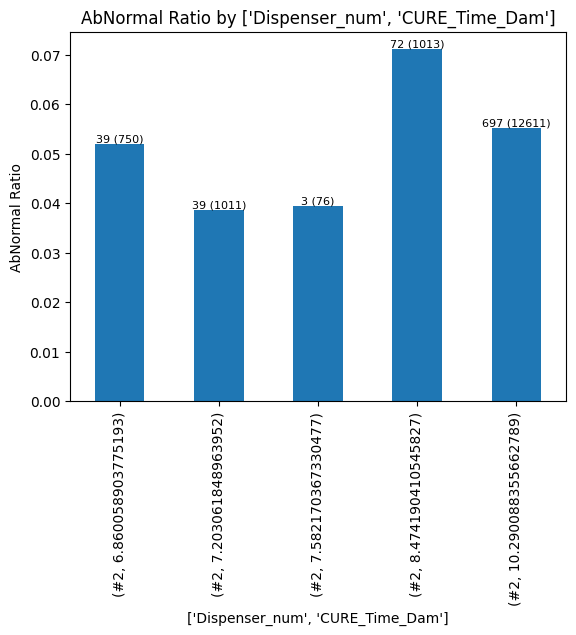

In [570]:
plot_ratio(train_data, ['Dispenser_num','CURE_Time_Dam'])

In [571]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'CURE' in col]

print("\n Dam 공정 관련 변수 중 CURE 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE_DISTANCE_Dam
CURE_Time_Dam


In [572]:
train_data.drop(columns=[
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
], inplace=True)

test_data.drop(columns=[
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
], inplace=True)

c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [573]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'CURE' in col]

print("\n Dam 공정 관련 변수 중 CURE 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 CURE 포함 변수>
CURE_Time_Dam


In [574]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'HEAD NORMAL' in col]

print("\n Dam 공정 관련 변수 중 CURE 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 CURE 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam


In [575]:
summarize_group(train_data, ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
                            , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'
                            , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'])

Grouped by: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam, HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam

                       group  'AdNormal' count     ratio  Total
0     (161.2, 1271.8, 281.3)                 2  0.036364     55
1   (161.2, 1271.8, 281.324)                 8  0.023952    334
2   (161.2, 1271.8, 281.424)                 0  0.000000     29
3    (161.2, 1271.8, 281.43)                14  0.034398    407
4   (161.7, 1271.8, 280.894)                19  0.038855    489
5    (162.4, 1269.0, 282.15)               156  0.087838   1776
6     (162.4, 1269.0, 284.6)                 0  0.000000      1
7     (162.4, 1269.0, 284.8)                 0  0.000000      1
8    (162.4, 1271.3, 282.15)                53  0.050189   1056
9     (162.4, 1271.8, 274.0)                21  0.055263    380
10    (162.4, 1271.8, 274.2)                32  0.041078    779
11   (162.4, 1271.8, 274.33)                22

In [576]:
summarize_group(train_data, ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'
                            , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'
                            , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'])

Grouped by: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam

                       group  'AdNormal' count     ratio  Total
0     (464.2, 1383.9, 281.3)                 2  0.036364     55
1   (464.2, 1383.9, 281.324)                 8  0.023952    334
2   (464.2, 1383.9, 281.424)                 0  0.000000     29
3    (464.2, 1383.9, 281.43)                14  0.034398    407
4   (464.7, 1383.9, 280.894)                19  0.038855    489
5    (465.1, 1268.2, 282.15)                28  0.068796    407
6    (465.1, 1268.4, 282.15)               104  0.094288   1103
7    (465.1, 1268.8, 282.15)                23  0.111650    206
8     (465.1, 1268.8, 284.6)                 0  0.000000      1
9     (465.1, 1268.8, 284.8)                 0  0.000000      1
10   (465.3, 1268.2, 282.15)                 1  0.016667     60
11   (465.3, 1270.7, 282.15)                53

In [577]:
summary_df = summarize_group(train_data, ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
                                                 , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'
                                                 , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'])

Grouped by: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam, HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam

                       group  'AdNormal' count     ratio  Total
0     (550.5, 1271.8, 281.3)                 2  0.036364     55
1   (550.5, 1271.8, 281.324)                 8  0.023952    334
2   (550.5, 1271.8, 281.424)                 0  0.000000     29
3    (550.5, 1271.8, 281.43)                14  0.034398    407
4   (551.0, 1271.8, 280.894)                19  0.038855    489
5     (551.1, 1269.0, 284.6)                 0  0.000000      1
6     (551.1, 1269.0, 284.8)                 0  0.000000      1
7    (551.3, 1269.0, 282.15)               156  0.087838   1776
8    (551.3, 1271.3, 282.15)                53  0.050237   1055
9     (551.7, 1271.8, 274.0)                21  0.055263    380
10    (551.7, 1271.8, 274.2)                32  0.041078    779
11   (551.7, 1271.8, 274.33)                22

<Figure size 1000x500 with 0 Axes>

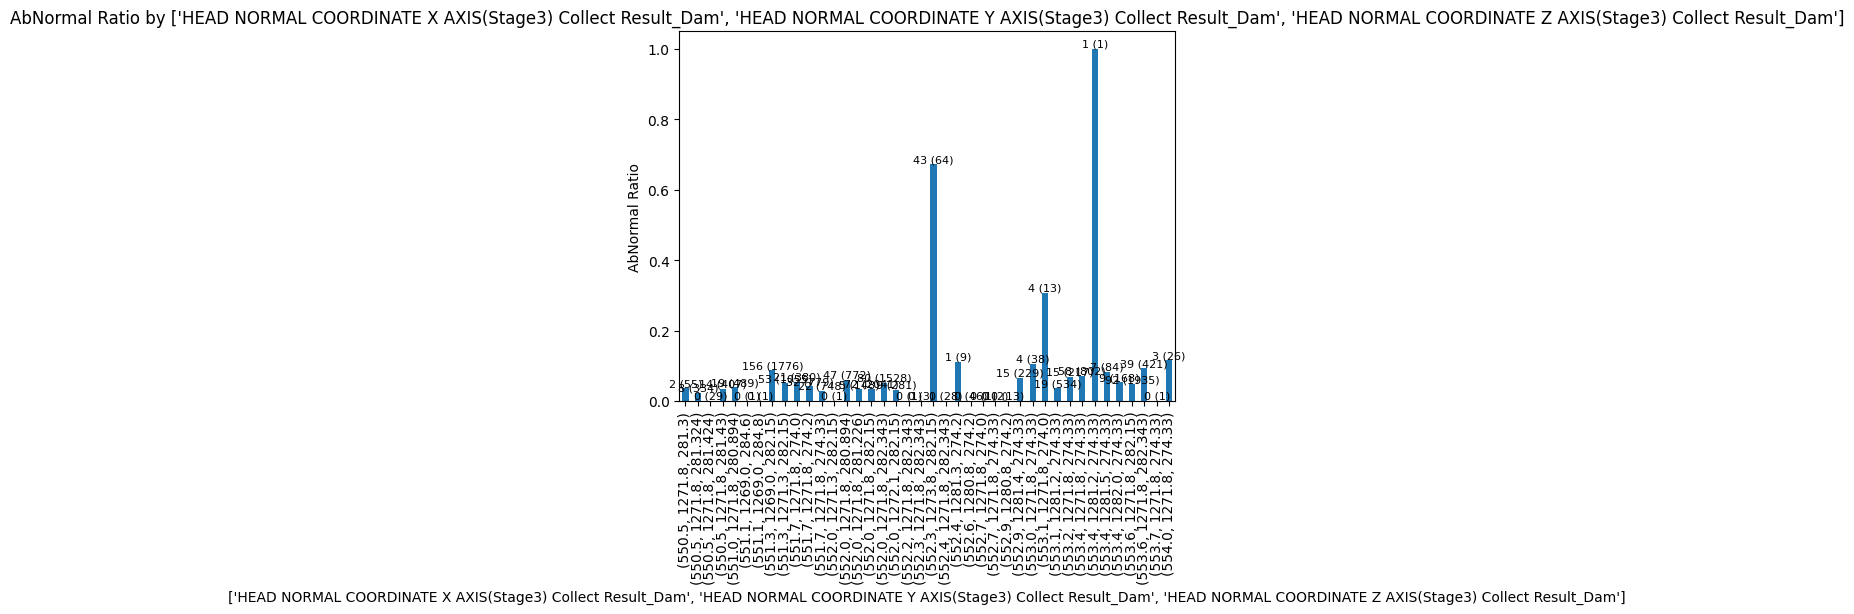

In [578]:
plot_ratio(train_data, ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
                                                 , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'
                                                 , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'])

In [579]:
import numpy as np

# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']

# 거리 계산 함수
def calculate_distances(data):
    data['DISTANCE_STAGE1_STAGE2_Dam'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE2_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE1_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [580]:
summary_df = summarize_group(train_data, [
    'DISTANCE_STAGE1_STAGE2_Dam'
    , 'DISTANCE_STAGE2_STAGE3_Dam'
    , 'DISTANCE_STAGE1_STAGE3_Dam'])

Grouped by: DISTANCE_STAGE1_STAGE2_Dam, DISTANCE_STAGE2_STAGE3_Dam, DISTANCE_STAGE1_STAGE3_Dam

                                                          group  \
0    (302.70006607201134, 86.0002325578251, 388.70000000000005)   
1                (302.70006607201134, 86.20023201824917, 388.9)   
2                 (302.7005946475825, 86.20208814176132, 388.9)   
3                   (302.70105715045, 86.20371221705008, 388.9)   
4                (302.90059425494695, 86.00209299778692, 388.9)   
5                (302.90105645243295, 86.00372084973992, 388.9)   
6     (302.901997352279, 86.50699393690662, 389.40000000000003)   
7                (303.10059386282967, 86.50208089982576, 389.6)   
8                 (303.1019960343383, 86.50699393690662, 389.6)   
9                 (303.1032332391062, 86.51132873791732, 389.6)   
10              (322.41541526422094, 141.96062834462245, 389.4)   
11               (322.6967151986522, 141.59329080150667, 389.1)   
12               (322.69671519865

<Figure size 1000x500 with 0 Axes>

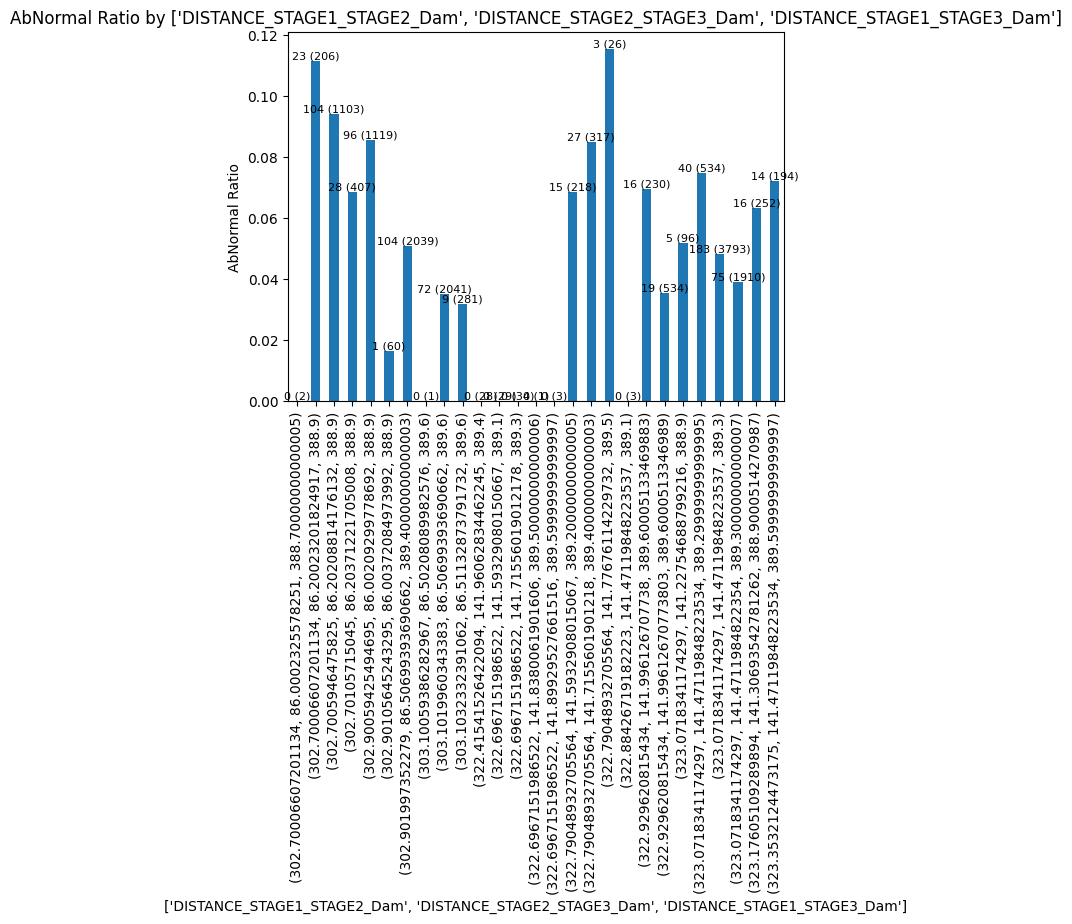

In [581]:
plot_ratio(train_data, [
    'DISTANCE_STAGE1_STAGE2_Dam'
    , 'DISTANCE_STAGE2_STAGE3_Dam'
    , 'DISTANCE_STAGE1_STAGE3_Dam'])

In [583]:
# 결과 출력
value_counts_ratio(train_data, 'DISTANCE_STAGE1_STAGE2_Dam')
# value_counts_ratio_count(train_data, 'DISTANCE_STAGE2_STAGE3_Dam', 'target')
# value_counts_ratio_count(train_data, 'DISTANCE_STAGE1_STAGE3_Dam', 'target')


DISTANCE_STAGE1_STAGE2_Dam별 target 비율 및 갯수

            AbNormal    Normal  AbNormal  Normal  Total
variable                                               
302.700066  0.110577  0.889423      23.0   185.0    208
302.700595  0.094288  0.905712     104.0   999.0   1103
302.701057  0.068796  0.931204      28.0   379.0    407
302.900594  0.085791  0.914209      96.0  1023.0   1119
302.901056  0.016667  0.983333       1.0    59.0     60
302.901997  0.051005  0.948995     104.0  1935.0   2039
303.100594  0.000000  1.000000       0.0     1.0      1
303.101996  0.035277  0.964723      72.0  1969.0   2041
303.103233  0.032028  0.967972       9.0   272.0    281
322.415415  0.000000  1.000000       0.0    28.0     28
322.696715  0.000000  1.000000       0.0    67.0     67
322.790489  0.080214  0.919786      45.0   516.0    561
322.884267  0.000000  1.000000       0.0     3.0      3
322.929621  0.045812  0.954188      35.0   729.0    764
323.071834  0.047845  0.952155     303.0  6030.0   6333
323

In [336]:
summarize_group(train_data, ['Dispenser_num', 'DISTANCE_STAGE1_STAGE2_Dam'])

Grouped by: Dispenser_num, DISTANCE_STAGE1_STAGE2_Dam

                       group  'AdNormal' count     ratio  Total
0   (#2, 302.70006607201134)                23  0.110577    208
1    (#2, 302.7005946475825)               104  0.094288   1103
2      (#2, 302.70105715045)                28  0.068796    407
3   (#2, 302.90059425494695)                96  0.085791   1119
4   (#2, 302.90105645243295)                 1  0.016667     60
5     (#2, 302.901997352279)               104  0.051005   2039
6   (#2, 303.10059386282967)                 0  0.000000      1
7    (#2, 303.1019960343383)                72  0.035277   2041
8    (#2, 303.1032332391062)                 9  0.032028    281
9   (#2, 322.41541526422094)                 0  0.000000     28
10   (#2, 322.6967151986522)                 0  0.000000     67
11  (#2, 322.79048932705564)                45  0.080214    561
12  (#2, 322.88426719182223)                 0  0.000000      3
13    (#2, 322.929620815434)                35  0

In [ ]:
summarize_group(train_data, ['Dispenser_num', 'DISTANCE_STAGE1_STAGE2_Dam'])

In [337]:
train_data['DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam'] = train_data['DISTANCE_STAGE1_STAGE2_Dam'] + train_data['DISTANCE_STAGE2_STAGE3_Dam']
test_data['DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam'] = test_data['DISTANCE_STAGE1_STAGE2_Dam'] + test_data['DISTANCE_STAGE2_STAGE3_Dam']

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [338]:
summary_df = summarize_group(train_data, [
    'DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam'
    , 'DISTANCE_STAGE1_STAGE3_Dam'
    ])

Grouped by: DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam, DISTANCE_STAGE1_STAGE3_Dam

                                       group  'AdNormal' count     ratio  \
0    (388.7002986298364, 388.70000000000005)                 0  0.000000   
1                 (388.9002980902605, 388.9)                23  0.111650   
2                (388.90268278934377, 388.9)               104  0.094288   
3                (388.90268725273387, 388.9)                96  0.085791   
4                 (388.9047693675001, 388.9)                28  0.068796   
5                 (388.9047773021729, 388.9)                 1  0.016667   
6    (389.4089912891856, 389.40000000000003)               104  0.051005   
7                 (389.6026747626554, 389.6)                 0  0.000000   
8                 (389.6089899712449, 389.6)                72  0.035277   
9                 (389.6145619770235, 389.6)                 9  0.032028   
10                (464.2900060001589, 389.1)                 0  0.000000   
11          

In [339]:
train_data['diff_DISTANCE_stage_Dam'] = train_data['DISTANCE_STAGE1_STAGE3_Dam'] - train_data['DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam']
test_data['diff_DISTANCE_stage_Dam'] = test_data['DISTANCE_STAGE1_STAGE3_Dam'] - test_data['DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam']

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [340]:
value_counts_ratio(train_data, 'diff_DISTANCE_stage_Dam', 'target')


diff_DISTANCE_stage_Dam별 target 비율 및 갯수

            AbNormal    Normal  AbNormal  Normal  Total
variable                                               
-75.582935  0.063492  0.936508      16.0   236.0    252
-75.399381  0.052083  0.947917       5.0    91.0     96
-75.325696  0.069565  0.930435      16.0   214.0    230
-75.325696  0.035581  0.964419      19.0   515.0    534
-75.255466  0.000000  1.000000       0.0     3.0      3
-75.243033  0.047779  0.952221     298.0  5939.0   6237
-75.224411  0.072165  0.927835      14.0   180.0    194
-75.190006  0.000000  1.000000       0.0    29.0     29
-75.183780  0.068807  0.931193      15.0   203.0    218
-75.112275  0.000000  1.000000       0.0    34.0     34
-75.106050  0.085174  0.914826      27.0   290.0    317
-75.067250  0.115385  0.884615       3.0    23.0     26
-75.034721  0.000000  1.000000       0.0     1.0      1
-74.996010  0.000000  1.000000       0.0     3.0      3
-74.976044  0.000000  1.000000       0.0    28.0     28
-0.014

In [341]:
# 결과 출력
value_counts_ratio(train_data, 'DISTANCE_STAGE1_STAGE2_Dam', 'target')
# value_counts_ratio_count(train_data, 'DISTANCE_STAGE2_STAGE3_Dam', 'target')
# value_counts_ratio_count(train_data, 'DISTANCE_STAGE1_STAGE3_Dam', 'target')


DISTANCE_STAGE1_STAGE2_Dam별 target 비율 및 갯수

            AbNormal    Normal  AbNormal  Normal  Total
variable                                               
302.700066  0.110577  0.889423      23.0   185.0    208
302.700595  0.094288  0.905712     104.0   999.0   1103
302.701057  0.068796  0.931204      28.0   379.0    407
302.900594  0.085791  0.914209      96.0  1023.0   1119
302.901056  0.016667  0.983333       1.0    59.0     60
302.901997  0.051005  0.948995     104.0  1935.0   2039
303.100594  0.000000  1.000000       0.0     1.0      1
303.101996  0.035277  0.964723      72.0  1969.0   2041
303.103233  0.032028  0.967972       9.0   272.0    281
322.415415  0.000000  1.000000       0.0    28.0     28
322.696715  0.000000  1.000000       0.0    67.0     67
322.790489  0.080214  0.919786      45.0   516.0    561
322.884267  0.000000  1.000000       0.0     3.0      3
322.929621  0.045812  0.954188      35.0   729.0    764
323.071834  0.047845  0.952155     303.0  6030.0   6333
323

In [342]:
train_data['DISTANCE_STAGE1_STAGE2_Dam']

2        323.071834
3        303.101996
7        323.071834
10       323.071834
11       323.071834
12       302.901997
13       303.101996
21       323.071834
26       302.901997
30       323.071834
32       323.071834
33       323.071834
34       323.071834
35       323.071834
38       302.900594
39       302.901997
42       302.901997
43       302.900594
47       303.103233
49       323.071834
55       323.071834
56       302.700595
60       303.101996
65       323.071834
66       323.353212
67       323.071834
68       323.071834
71       322.929621
72       323.071834
73       323.071834
74       323.071834
77       303.101996
80       302.900594
85       323.071834
87       303.101996
91       323.071834
95       302.901997
108      323.071834
109      322.790489
110      302.901997
111      322.929621
117      302.901997
118      303.101996
119      323.071834
120      323.071834
121      303.101996
122      323.071834
125      323.071834
131      302.901997
136      322.929621


In [343]:
import numpy as np

# 필요한 열 이름
stage1_stage2_col = 'DISTANCE_STAGE1_STAGE2_Dam'
stage2_stage3_col = 'DISTANCE_STAGE2_STAGE3_Dam'
stage1_stage3_col = 'DISTANCE_STAGE1_STAGE3_Dam'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['DISTANCE_TRIANGLE_area_Dam'] = area
    data['DISTANCE_TRIANGLE_height_Dam'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [344]:
value_counts_ratio(train_data, 'DISTANCE_TRIANGLE_area_Dam', 'target')


DISTANCE_TRIANGLE_area_Dam별 target 비율 및 갯수

           AbNormal    Normal  AbNormal  Normal  Total
variable                                              
38.870     0.000000  1.000000       0.0     2.0      2
38.890     0.111650  0.888350      23.0   183.0    206
116.670    0.094288  0.905712     104.0   999.0   1103
116.670    0.085791  0.914209      96.0  1023.0   1119
116.880    0.000000  1.000000       0.0     1.0      1
155.560    0.016667  0.983333       1.0    59.0     60
155.560    0.068796  0.931204      28.0   379.0    407
214.170    0.051005  0.948995     104.0  1935.0   2039
214.280    0.035277  0.964723      72.0  1969.0   2041
272.720    0.032028  0.967972       9.0   272.0    281
21797.845  0.052083  0.947917       5.0    91.0     96
21809.055  0.000000  1.000000       0.0    29.0     29
21809.055  0.000000  1.000000       0.0     3.0      3
21814.660  0.068807  0.931193      15.0   203.0    218
21820.265  0.074906  0.925094      40.0   494.0    534
21820.265  0.048247 

In [345]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, ['Dispenser_num', 'DISTANCE_TRIANGLE_area_Dam'])

# 결과 출력
print(summary_df)

Grouped by: Dispenser_num, DISTANCE_TRIANGLE_area_Dam

                       group  'AdNormal' count     ratio  Total
0    (#2, 38.86999999949112)                 0  0.000000      2
1   (#2, 38.889999995880395)                23  0.111650    206
2   (#2, 116.66999999970827)               104  0.094288   1103
3   (#2, 116.67000000049923)                96  0.085791   1119
4   (#2, 116.87999999953863)                 0  0.000000      1
5    (#2, 155.5599999986743)                 1  0.016667     60
6    (#2, 155.5599999992734)                28  0.068796    407
7    (#2, 214.1700000001986)               104  0.051005   2039
8   (#2, 214.28000000011698)                72  0.035277   2041
9    (#2, 272.7200000000176)                 9  0.032028    281
10  (#2, 21797.845000000023)                 5  0.052083     96
11  (#2, 21809.055000000033)                 0  0.000000     29
12  (#2, 21809.055000000044)                 0  0.000000      3
13   (#2, 21814.66000000002)                15  0

In [346]:
value_counts_ratio(train_data, 'DISTANCE_TRIANGLE_height_Dam', 'target')


DISTANCE_TRIANGLE_height_Dam별 target 비율 및 갯수

            AbNormal    Normal  AbNormal  Normal  Total
variable                                               
0.200000    0.111650  0.888350      23.0   183.0    206
0.200000    0.000000  1.000000       0.0     2.0      2
0.600000    0.000000  1.000000       0.0     1.0      1
0.600000    0.094288  0.905712     104.0   999.0   1103
0.600000    0.085791  0.914209      96.0  1023.0   1119
0.800000    0.016667  0.983333       1.0    59.0     60
0.800000    0.068796  0.931204      28.0   379.0    407
1.100000    0.035277  0.964723      72.0  1969.0   2041
1.100000    0.051005  0.948995     104.0  1935.0   2039
1.400000    0.032028  0.967972       9.0   272.0    281
112.100000  0.000000  1.000000       0.0     3.0      3
112.100000  0.000000  1.000000       0.0    28.0     28
112.100000  0.068807  0.931193      15.0   203.0    218
112.100000  0.074766  0.925234      40.0   495.0    535
112.100000  0.052083  0.947917       5.0    91.0     96
1

In [347]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, ['Dispenser_num', 'DISTANCE_TRIANGLE_height_Dam'])

# 결과 출력
print(summary_df)

Grouped by: Dispenser_num, DISTANCE_TRIANGLE_height_Dam

                        group  'AdNormal' count     ratio  Total
0   (#2, 0.19999999997881407)                23  0.111650    206
1    (#2, 0.1999999999973816)                 0  0.000000      2
2    (#2, 0.5999999999976315)                 0  0.000000      1
3    (#2, 0.5999999999984997)               104  0.094288   1103
4    (#2, 0.6000000000025675)                96  0.085791   1119
5    (#2, 0.7999999999931824)                 1  0.016667     60
6    (#2, 0.7999999999962634)                28  0.068796    407
7    (#2, 1.1000000000006005)                72  0.035277   2041
8      (#2, 1.10000000000102)               104  0.051005   2039
9    (#2, 1.4000000000000903)                 9  0.032028    281
10   (#2, 112.10000000000005)                 0  0.000000      3
11   (#2, 112.10000000000008)                 0  0.000000     28
12    (#2, 112.1000000000001)                15  0.068807    218
13   (#2, 112.10000000000011)    

In [348]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Z

In [349]:
# 'Stage1 Circle'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'Stage1 Circle' in col]

print("\n Dam 공정 관련 변수 중 Stage1 Circle 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 Stage1 Circle 포함 변수>
Stage1 Circle1 Distance Speed Collect Result_Dam
Stage1 Circle2 Distance Speed Collect Result_Dam
Stage1 Circle3 Distance Speed Collect Result_Dam
Stage1 Circle4 Distance Speed Collect Result_Dam


In [350]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, [
    'Stage1 Circle1 Distance Speed Collect Result_Dam'
    , 'Stage1 Circle2 Distance Speed Collect Result_Dam'
    , 'Stage1 Circle3 Distance Speed Collect Result_Dam'
    , 'Stage1 Circle4 Distance Speed Collect Result_Dam'
    ])

Grouped by: Stage1 Circle1 Distance Speed Collect Result_Dam, Stage1 Circle2 Distance Speed Collect Result_Dam, Stage1 Circle3 Distance Speed Collect Result_Dam, Stage1 Circle4 Distance Speed Collect Result_Dam

                      group  'AdNormal' count     ratio  Total
0  (4000, 4000, 4000, 4000)               147  0.048213   3049
1  (5000, 5000, 5000, 5000)               181  0.076695   2360
2  (5800, 5800, 5800, 5800)               142  0.057051   2489
3  (6000, 6000, 6000, 6000)                32  0.052202    613
4  (6200, 6200, 6200, 6200)                 7  0.051095    137
5  (6500, 6500, 6500, 6500)               313  0.049431   6332
6  (9000, 9000, 9000, 9000)                28  0.058212    481


In [351]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, [
    'Stage1 Line1 Distance Speed Collect Result_Dam'
    , 'Stage1 Line2 Distance Speed Collect Result_Dam'
    , 'Stage1 Line3 Distance Speed Collect Result_Dam'
    , 'Stage1 Line4 Distance Speed Collect Result_Dam'
    ])

Grouped by: Stage1 Line1 Distance Speed Collect Result_Dam, Stage1 Line2 Distance Speed Collect Result_Dam, Stage1 Line3 Distance Speed Collect Result_Dam, Stage1 Line4 Distance Speed Collect Result_Dam

                       group  'AdNormal' count     ratio  Total
0   (4000, 4000, 4000, 4000)               147  0.048213   3049
1   (5000, 5000, 5000, 5000)               181  0.076695   2360
2   (5800, 5800, 5600, 5800)               116  0.060860   1906
3   (5800, 5800, 5800, 5800)                26  0.044597    583
4   (6000, 6000, 6000, 6000)                32  0.052202    613
5   (6200, 6200, 6200, 6200)                 7  0.051095    137
6   (6500, 6500, 6000, 6500)                 4  0.013605    294
7   (6500, 6500, 6500, 6500)               309  0.051184   6037
8   (9000, 9000, 9000, 9000)                28  0.058212    481
9  (13000, 6500, 6500, 6500)                 0  0.000000      1


In [352]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, [
    'Stage1 Circle1 Distance Speed Collect Result_Dam'
    , 'Stage1 Circle2 Distance Speed Collect Result_Dam'
    , 'Stage1 Circle3 Distance Speed Collect Result_Dam'
    , 'Stage1 Circle4 Distance Speed Collect Result_Dam'
    , 'Stage1 Line1 Distance Speed Collect Result_Dam'
    , 'Stage1 Line2 Distance Speed Collect Result_Dam'
    , 'Stage1 Line3 Distance Speed Collect Result_Dam'
    , 'Stage1 Line4 Distance Speed Collect Result_Dam'
    ])

Grouped by: Stage1 Circle1 Distance Speed Collect Result_Dam, Stage1 Circle2 Distance Speed Collect Result_Dam, Stage1 Circle3 Distance Speed Collect Result_Dam, Stage1 Circle4 Distance Speed Collect Result_Dam, Stage1 Line1 Distance Speed Collect Result_Dam, Stage1 Line2 Distance Speed Collect Result_Dam, Stage1 Line3 Distance Speed Collect Result_Dam, Stage1 Line4 Distance Speed Collect Result_Dam

                                               group  'AdNormal' count  \
0   (4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000)               147   
1   (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000)               181   
2   (5800, 5800, 5800, 5800, 5800, 5800, 5600, 5800)               116   
3   (5800, 5800, 5800, 5800, 5800, 5800, 5800, 5800)                26   
4   (6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000)                32   
5   (6200, 6200, 6200, 6200, 6200, 6200, 6200, 6200)                 7   
6   (6500, 6500, 6500, 6500, 6500, 6500, 6000, 6500)                 4   
7   

In [353]:
# 'Stage1 Circle'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'Stage2 Line' in col]

print("\n Dam 공정 관련 변수 중 Stage1 Line 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 Stage1 Line 포함 변수>
Stage2 Line1 Distance Speed Collect Result_Dam
Stage2 Line2 Distance Speed Collect Result_Dam
Stage2 Line3 Distance Speed Collect Result_Dam
Stage2 Line4 Distance Speed Collect Result_Dam


In [354]:
# 'Stage1 Circle'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'Stage2 Circle' in col]

print("\n Dam 공정 관련 변수 중 Stage1 Circle 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 Stage1 Circle 포함 변수>
Stage2 Circle1 Distance Speed Collect Result_Dam
Stage2 Circle2 Distance Speed Collect Result_Dam
Stage2 Circle3 Distance Speed Collect Result_Dam
Stage2 Circle4 Distance Speed Collect Result_Dam


In [355]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, [
    'Stage2 Circle1 Distance Speed Collect Result_Dam'
    , 'Stage2 Circle2 Distance Speed Collect Result_Dam'
    , 'Stage2 Circle3 Distance Speed Collect Result_Dam'
    , 'Stage2 Circle4 Distance Speed Collect Result_Dam'
    , 'Stage2 Line1 Distance Speed Collect Result_Dam'
    , 'Stage2 Line2 Distance Speed Collect Result_Dam'
    , 'Stage2 Line3 Distance Speed Collect Result_Dam'
    , 'Stage2 Line4 Distance Speed Collect Result_Dam'
    ])

Grouped by: Stage2 Circle1 Distance Speed Collect Result_Dam, Stage2 Circle2 Distance Speed Collect Result_Dam, Stage2 Circle3 Distance Speed Collect Result_Dam, Stage2 Circle4 Distance Speed Collect Result_Dam, Stage2 Line1 Distance Speed Collect Result_Dam, Stage2 Line2 Distance Speed Collect Result_Dam, Stage2 Line3 Distance Speed Collect Result_Dam, Stage2 Line4 Distance Speed Collect Result_Dam

                                                       group  \
0           (4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000)   
1           (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000)   
2           (5300, 5300, 5300, 5300, 5300, 5300, 5300, 5300)   
3           (5500, 5500, 5500, 5500, 5500, 5500, 5500, 5500)   
4           (5500, 5500, 5500, 5500, 5500, 5800, 5500, 5800)   
5           (6000, 6000, 6000, 6000, 5500, 6000, 5000, 6000)   
6           (6500, 6500, 6500, 6500, 5000, 6500, 5000, 6500)   
7           (6500, 6500, 6500, 6500, 5500, 6500, 5500, 6500)   
8           (6500, 6

In [356]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, [
    'Stage3 Circle1 Distance Speed Collect Result_Dam'
    , 'Stage3 Circle2 Distance Speed Collect Result_Dam'
    , 'Stage3 Circle3 Distance Speed Collect Result_Dam'
    , 'Stage3 Circle4 Distance Speed Collect Result_Dam'
    , 'Stage3 Line1 Distance Speed Collect Result_Dam'
    , 'Stage3 Line2 Distance Speed Collect Result_Dam'
    , 'Stage3 Line3 Distance Speed Collect Result_Dam'
    , 'Stage3 Line4 Distance Speed Collect Result_Dam'
    ])

Grouped by: Stage3 Circle1 Distance Speed Collect Result_Dam, Stage3 Circle2 Distance Speed Collect Result_Dam, Stage3 Circle3 Distance Speed Collect Result_Dam, Stage3 Circle4 Distance Speed Collect Result_Dam, Stage3 Line1 Distance Speed Collect Result_Dam, Stage3 Line2 Distance Speed Collect Result_Dam, Stage3 Line3 Distance Speed Collect Result_Dam, Stage3 Line4 Distance Speed Collect Result_Dam

                                              group  'AdNormal' count  \
0  (4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000)               147   
1  (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000)               181   
2  (5800, 5800, 5800, 5800, 5800, 5800, 5800, 5800)               142   
3  (6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000)                35   
4  (6200, 6200, 6200, 6200, 6200, 6200, 6200, 6200)                 7   
5  (6500, 6500, 6500, 6500, 6500, 6500, 6000, 6500)                 4   
6  (6500, 6500, 6500, 6500, 6500, 6500, 6500, 6500)               306   
7  (9000, 90

In [357]:
import pandas as pd

# '_Dam'를 포함하는 열 이름 필터링 함수
def filter_dam_columns(data):
    return data.filter(like='_Dam').columns

# 스테이지별로 파생변수 생성 함수
def create_stage_variables(data, columns):
    stages = ['Stage1', 'Stage2', 'Stage3']
    for stage in stages:
        stage_cols = [col for col in columns if stage in col]
        new_col_name = f'{stage}_Total_Distance_Speed_Collect_Result_Dam'
        data[new_col_name] = data[stage_cols].sum(axis=1)
        # 이전 변수 삭제
        data.drop(columns=stage_cols, inplace=True)
    return data

# train_data에 적용
train_dam_columns = filter_dam_columns(train_data)
train_data = create_stage_variables(train_data, train_dam_columns)

# test_data에 적용
test_dam_columns = filter_dam_columns(test_data)
test_data = create_stage_variables(test_data, test_dam_columns)

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]
C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [358]:
train_data['Stage1_Total_Distance_Speed_Collect_Result_Dam'].value_counts().head()

33739.140    2006
53730.963    1497
41731.740    1279
53732.800    1212
41734.040    1056
Name: Stage1_Total_Distance_Speed_Collect_Result_Dam, dtype: int64

In [359]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
Machine Tact time Collect Result_Dam
PalletID Collect Result_Dam
Production Qty Collect Result_Dam
Receip No Collect Result_Dam
THICKNESS 1 Collect Result_Dam
THICKNESS 2 Collect Result_Dam
THICKNESS 3 Collect Result_Dam
WorkMode Collect Result_Dam
CURE_Time_Dam
DISTANCE_STAGE1_STAGE2_Dam
DISTANCE_STAGE2_STAGE3_Dam
DISTANCE_STAGE1_STAGE3_Dam
DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam
diff_DISTANCE_stage_Dam
DISTANCE_TRIANGLE_area_Dam
DISTANCE_TRIANGLE_height_Dam
Stage1_Total_Distance_Speed_Collect_Result_Dam
Stage2_Total_Distance_Speed_Collect_Result_Dam
Stage3_Total_Distance_Speed_Collect_Result_Dam


In [441]:
# 'THICKNESS'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'THICKNESS' in col]

print("\n Dam 공정 관련 변수 중 THICKNESS 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 THICKNESS 포함 변수>
THICKNESS 1 Collect Result_Dam
THICKNESS 2 Collect Result_Dam
THICKNESS 3 Collect Result_Dam


In [360]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, [
    'THICKNESS 1 Collect Result_Dam'
    , 'THICKNESS 2 Collect Result_Dam'
    , 'THICKNESS 3 Collect Result_Dam'
    ])

Grouped by: THICKNESS 1 Collect Result_Dam, THICKNESS 2 Collect Result_Dam, THICKNESS 3 Collect Result_Dam

                      group  'AdNormal' count     ratio  Total
0   (-0.054, -0.219, 0.007)                19  0.044917    423
1  (-0.019, -0.021, -0.118)                40  0.049322    811
2  (-0.015, -0.036, -0.026)                34  0.081535    417
3           (0.0, 0.0, 0.0)               708  0.054095  13088
4    (0.012, -0.022, 0.003)                 1  0.016949     59
5    (0.014, -0.058, 0.012)                41  0.077947    526
6     (0.014, 0.007, 0.012)                 3  0.038961     77
7     (0.037, 0.005, 0.024)                 4  0.066667     60


In [361]:
# 새로운 파생변수 생성 함수
def create_total_thickness_dam(data):
    data['Total_THICKNESS_Collect_Result_Dam'] = (
        data['THICKNESS 1 Collect Result_Dam'] +
        data['THICKNESS 2 Collect Result_Dam'] +
        data['THICKNESS 3 Collect Result_Dam']
    )
    # 기존 변수 삭제
    data.drop(columns=[
        'THICKNESS 1 Collect Result_Dam',
        'THICKNESS 2 Collect Result_Dam',
        'THICKNESS 3 Collect Result_Dam'
    ], inplace=True)
    return data

train_data = create_total_thickness_dam(train_data)
test_data = create_total_thickness_dam(test_data)

C:\Users\juneh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [362]:
value_counts_ratio(train_data, 'Total_THICKNESS_Collect_Result_Dam', 'target')


Total_THICKNESS_Collect_Result_Dam별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
-0.266    0.044917  0.955083        19     404    423
-0.158    0.049322  0.950678        40     771    811
-0.077    0.081535  0.918465        34     383    417
-0.032    0.077947  0.922053        41     485    526
-0.007    0.016949  0.983051         1      58     59
 0.000    0.054095  0.945905       708   12380  13088
 0.033    0.038961  0.961039         3      74     77
 0.066    0.066667  0.933333         4      56     60


In [363]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
Machine Tact time Collect Result_Dam
PalletID Collect Result_Dam
Production Qty Collect Result_Dam
Receip No Collect Result_Dam
WorkMode Collect Result_Dam
CURE_Time_Dam
DISTANCE_STAGE1_STAGE2_Dam
DISTANCE_STAGE2_STAGE3_Dam
DISTANCE_STAGE1_STAGE3_Dam
DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam
diff_DISTANCE_stage_Dam
DISTANCE_TRIANGLE_area_Dam
DISTANCE_TRIANGLE_height_Dam
Stage1_Total_Distance_Speed_Collect_Result_Dam
Stage2_Total_Distance_Speed_Collect_Result_Dam
Stage3_Total_Distance_Speed_Collect_Result_Dam
Total_THICKNESS_Collect_Result_Dam


In [364]:
# 'Head'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns
filtered_columns = [col for col in Process_Desc_col if 'Head' in col]

print("\n Dam 공정 관련 변수 중 Head 포함 변수>")
for col in filtered_columns:
    print(col)


 Dam 공정 관련 변수 중 Head 포함 변수>
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam


In [365]:
import pandas as pd

# pandas 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 데이터 요약
summary_df = summarize_group(train_data, [
    'Head Clean Position Z Collect Result_Dam'
    , 'Head Purge Position Z Collect Result_Dam'
    , 'Head Zero Position Y Collect Result_Dam'
    , 'Head Zero Position Z Collect Result_Dam'
    ])

Grouped by: Head Clean Position Z Collect Result_Dam, Head Purge Position Z Collect Result_Dam, Head Zero Position Y Collect Result_Dam, Head Zero Position Z Collect Result_Dam

                             group  'AdNormal' count     ratio  Total
0  (118.85, 130.85, 300.0, 265.02)                 0  0.000000     19
1    (124.0, 130.85, 300.0, 265.0)                43  0.048045    895
2   (124.0, 130.85, 300.0, 265.02)               168  0.052880   3177
3   (130.85, 130.85, 300.0, 265.0)               375  0.053222   7046
4  (130.85, 130.85, 300.0, 265.02)               221  0.051902   4258
5   (130.85, 130.85, 303.5, 265.0)                43  0.671875     64
6     (133.5, 133.5, 300.0, 265.0)                 0  0.000000      2


In [366]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
Machine Tact time Collect Result_Dam
PalletID Collect Result_Dam
Production Qty Collect Result_Dam
Receip No Collect Result_Dam
WorkMode Collect Result_Dam
CURE_Time_Dam
DISTANCE_STAGE1_STAGE2_Dam
DISTANCE_STAGE2_STAGE3_Dam
DISTANCE_STAGE1_STAGE3_Dam
DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam
diff_DISTANCE_stage_Dam
DISTANCE_TRIANGLE_area_Dam
DISTANCE_TRIANGLE_height_Dam
Stage1_Total_Distance_Speed_Collect_Result_Dam
Stage2_Total_Distance_Speed_Collect_Result_Dam
Stage3_Total_Distance_Speed_Collect_Result_Dam
Total_THICKNESS_Collect_Result_Dam


In [367]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'DISTANCE_STAGE1_STAGE2_Dam'
    , 'DISTANCE_STAGE2_STAGE3_Dam'
    , 'DISTANCE_STAGE1_STAGE3_Dam'
    , 'DISTANCE_STAGE(1-2)+STAGE(2-3)_Dam'
    , 'diff_DISTANCE_stage_Dam'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [368]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
Machine Tact time Collect Result_Dam
PalletID Collect Result_Dam
Production Qty Collect Result_Dam
Receip No Collect Result_Dam
WorkMode Collect Result_Dam
CURE_Time_Dam
DISTANCE_TRIANGLE_area_Dam
DISTANCE_TRIANGLE_height_Dam
Stage1_Total_Distance_Speed_Collect_Result_Dam
Stage2_Total_Distance_Speed_Collect_Result_Dam
Stage3_Total_Distance_Speed_Collect_Result_Dam
Total_THICKNESS_Collect_Result_Dam


## AutoClave

## Fill1

## Fill2

---